# Apply PCI to simulated data 
## Investigate the impact of individual noise contributions

Here we apply PCI to data simulated via the LISA Simulation Suite, following the simulation scripts.

The simulated datasets are 3 days long. PCI is applied to 12 hours of data, with 4 hours of skipped data at the beginning of the simulation.

We need the following simulated datasets:
- full simulation noise dataset (including laser noise and secondary noises), with filename ending in `_measurements_4Hz.h5`
- secondary noises dataset, with filename ending in `_noise_sec_4Hz.h5`

# 0. Installations and data generation

The package dependencies are:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install lisaconstants
    pip install lisainstrument
    pip install lisagwresponse
    pip install pytdi
    pip install backgrounds

and after installation, the data generation step is performed by running the simulation scripts: 

In [1]:
!pwd

/Users/ecastel2/Documents/virtual-envs/software-install/pcipy/notebooks


In [2]:
#!python ../simulation/noise_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2 --baseline --individual

In [3]:
#!python ../simulation/signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [4]:
#!python ../simulation/all_sky_signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [5]:
!ls -la /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations

total 89622808
drwxr-xr-x  76 ecastel2  staff       2432 Apr  9 19:15 .
drwxr-xr-x  21 ecastel2  staff        672 Mar 27 12:25 ..
-rw-r--r--@  1 ecastel2  staff      14340 Apr 15 21:34 .DS_Store
-rw-r--r--   1 ecastel2  staff   99542616 Apr  8 10:40 2025-04-08_equalarm_gw_measurements_4Hz.h5
-rw-r--r--   1 ecastel2  staff   24885248 Apr  8 10:40 2025-04-08_equalarm_gw_tdi1_4Hz.h5
-rw-r--r--   1 ecastel2  staff   24885248 Apr  8 10:40 2025-04-08_equalarm_gw_tdi2_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945592136 Apr  8 10:26 2025-04-08_equalarm_locking_N1-12_laser_tm_oms_measurements_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945592136 Apr  8 10:33 2025-04-08_equalarm_locking_N1-12_laser_tm_oms_noise_combined_laser_oms_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588736 Apr  8 10:31 2025-04-08_equalarm_locking_N1-12_laser_tm_oms_noise_combined_laser_test-mass_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588736 Apr  8 10:34 2025-04-08_equalarm_locking_N1-12_laser_tm_oms_noise_individual_laser_4Hz.h5

## 0.1 Settings and imports
Importing the relevant packages for the notebook. Setting up work directories.

In [6]:
import logging
import os

import h5py
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from datetime import datetime


from pytdi import Data
#from pytdi.intervar import ETA_SET
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2

from pcipy import plotting, pci_filter, channel_analysis 

# To print the logs
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [7]:
workdir = "/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/"

measpath = '_measurements_4Hz.h5'
secondpath = '_noise_sec_4Hz.h5'

#orbits = workdir+"keplerian-orbits.h5"
orbits = workdir+"equalarm-orbits.h5"

In [8]:
substring = ['equalarm_' + s for s in ['locking_N1-12_laser_tm_oms', 'all_sky_gw', 'gw']]
#substring = ['locking_six_laser_tm_oms', 'all_sky_gw', '2_gw']
sims = ["noise", "all_sky", "point_source"]
datasets = dict(zip(sims, substring))

matchfile={}
dtpath={}

for n,d in zip(substring,datasets):
    timestamp=[]
    matchfile[n] = [f for f in os.listdir(workdir) if n in f]
    for m in matchfile[n]:
        # pick latest date
        timestamp.append(datetime.strptime(m[:11], "%Y-%m-%d_"))
        #print(n, timestamp[n])
        dtpath[d] = max(timestamp).strftime("%Y-%m-%d_")
dtpath

{'noise': '2025-04-08_',
 'all_sky': '2025-04-09_',
 'point_source': '2025-04-08_'}

In [9]:
skip_hours=4
pci_hours=12

## 1. Build data vector of the six LISA single-link channels

To build the data vector of the six LISA single-link channels $\vec{y} = \left[y_{ij}\right]$, with $i,j=1,2,3$ and $i\neq j$ we resort to the intermediary TDI variables $\eta$, implemented within `pytdi` as `ETA_SET`.


We build the single link $\vec{y}$ data vector for the full noise simulation and for the secondary noises, ending up with two single link vectors:
- full simulation single link vector $\vec{y}^{\text{full}}$
- secondary noises single link vector $\vec{y}^{\text{sec}}$

In [10]:
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    y = np.array([data_noise.measurements[f'isi_{mosa}']/ central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full


def build_data_vector_etas(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full

In [11]:
# Get noise simulation measurements
simpath = workdir + dtpath['noise'] + datasets['noise'] + measpath
print(simpath)
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)

central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']
t0 = sim.attrs['t0']

fs = data_noise.fs

skip = int(skip_hours * 3600 * fs)  #We skip the earliest part of the sim which is not representative

y_full = build_data_vector(data_noise, skip=skip, dtype=np.float64)

INFO:pytdi.interface:Loading measurement file '/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-04-08_equalarm_locking_N1-12_laser_tm_oms_measurements_4Hz.h5'


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-04-08_equalarm_locking_N1-12_laser_tm_oms_measurements_4Hz.h5


INFO:pytdi.interface:Initializing data object
INFO:pytdi.interface:Computing delay derivatives


In [12]:
# Get secondary noises
secpath = workdir + dtpath['noise']+ datasets['noise'] + secondpath
print(secpath)

data_sec = Data.from_instrument(secpath)
    
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

INFO:pytdi.interface:Loading measurement file '/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-04-08_equalarm_locking_N1-12_laser_tm_oms_noise_sec_4Hz.h5'


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-04-08_equalarm_locking_N1-12_laser_tm_oms_noise_sec_4Hz.h5


INFO:pytdi.interface:Initializing data object
INFO:pytdi.interface:Computing delay derivatives


### 1.2 Data quicklook

Check the stencil size and take a look at the generated $y$s.

In [13]:
# TDI2 fractional delay Lagrange interpolating polynomials are of order 31=1+15*2
# Overall TDI delays are up to 8x single link delay = 8.34 s * 4 Hz * 8 = about 267 sample
# Add 15 on each end: 267 + 2*15 = 297   
# TDI2 overall stencil is then about 297 samples
# aPCI overall stencil width is 1 + nhalf*2
nhalf = 45
#ns = int(12 * 3600 * fs) # Use 12 hours data
ns = int(pci_hours * 3600 * fs) # For testing
window = np.ones(ns)

zsh:1: command not found: free


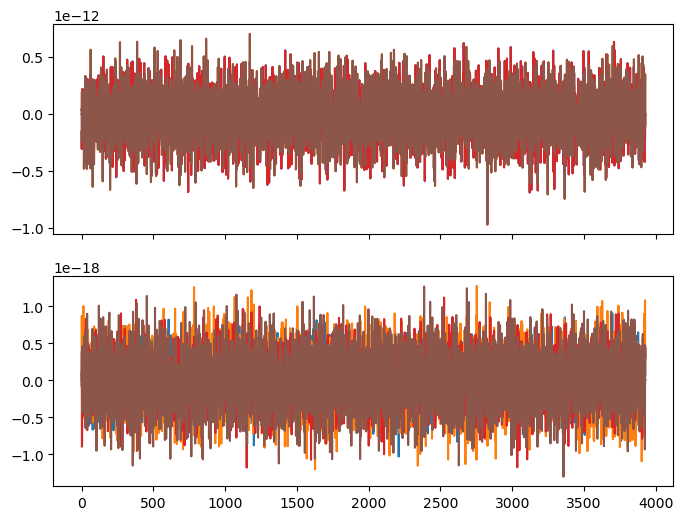

In [14]:
# Check time series
maxshow=4000
ev=ns//maxshow+1
_, axes = plt.subplots(2, 1, figsize=(8, 6), sharex = True)
for ich in range(len(y_full.T)):
    axes[0].plot(y_full[skip:skip+ns:ev, ich])
for ich in range(len(y_sec.T)):
    axes[1].plot(y_sec[skip:skip+ns:ev, ich])
!free

## 2. Apply PCI to the data

We now resort to {class}`PCIFilter` to evaluate PCI from $\vec{y}$.

An instance of {class}`PCIFilter` has two required inputs:
- `ydata`: matrix with the single link LISA temporal phase data streams $\vec{y}$ of length `ns`.
- `fs`: sampling rate of the data streams (Hz).

The optional parameters are
- `nhalf`: filter stencil halfwidth in samples. The default is 45.
- `order`: order of PCI. The default is 1.
- `maxcompts`: PCA results will be truncated to this length after initial processing. The default is 10.
- `Tscale`: if dt is None, then dt defaults to Tscale/ns

The input channels $\vec{y}$ are stretches of data, usually of length `ns+2*nhalf`, but sometimes varying. The variations are:
  - `:` (full length of matrix)
  - `0:ns_fixed`
  - `0:ns+2*nhalf`
  - `skip:skip+ns+2*nhalf`
  
In every case the window is trivial `np.ones([data lenght])`

The {py:class}`PCIFilter` class applies the following methods in order:

1. {py:meth}`pcipy.PCIFilter.build_data_matrix`
Pre-process $\vec{y}$ data `ydata` to build a matrix of shifted time-series. 

Output is a matrix $\vec{X}$ of size with size `ns` x `(2*nhalf+1)*nc` [what's `nc`?], where 

2. {py:meth}`pcipy.PCIFilter.apply_pca`

3. {py:meth}`pcipy.PCIFilter.set_stencil`

In [15]:
# import importlib
Tscale=10
# importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                 fs=fs, nhalf=nhalf, 
                                 order=q, 
                                 maxcompts=10, 
                                 sort_by_rms=False,
                                 Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 1.535552235354949
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1.10221624 1.1377015  1.22820899 1.17719949 1.16265807 1.12938381
 1.03584647 1.18890952 1.28887746 1.17999502]
channel covariance diagonality test on 10 components: 0.05940540436825639
component diagonality test on 10 components: 3.6972029311187194e-16
(172800, 1092)
variance check rms: 15.937630257774554
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[2.83982066 3.20375935 2.66652252 3.51126144 2.54603141 6.47330207
 4.71799002 5.48646158 4.38337587 7.00705418]
channel covariance diagonality test on 10 components: 0.14394779151722037
component diagonality test on 10 components: 6.395739347855843e-16
(172800, 1638)
variance check rms: 7294.777919355081
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[  92.8994527   103.20007901  156.8164514   361.14489277  331.24132918
  521.93437533  914.32904006  695.76227966 1351.14201012 7033

In [16]:
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list_rs = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    sort_by_rms=True,
                                    Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 1.535552235354949
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1.088174   1.1377015  1.10221624 1.17719949 1.16265807 1.28887746
 1.18890952 1.12938381 1.17999502 1.03584647]
channel covariance diagonality test on 10 components: 0.04989098798671073
component diagonality test on 10 components: 3.352654769722342e-16
(172800, 1092)
variance check rms: 15.937630257774552
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.06231264 1.06206668 1.06005673 1.3837289  1.04288884 1.05144995
 1.05557592 1.03395927 1.04001335 1.72843923]
channel covariance diagonality test on 10 components: 0.006912565923674827
component diagonality test on 10 components: 2.2027160074987677e-16
(172800, 1638)
variance check rms: 7294.7779193550805
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[2.07317774 1.99159442 1.94129169 1.88393719 1.87327717 1.82969374
 1.80617891 1.72535746 1.7233925  1.66394009]
channel covarianc

In [17]:
pca_list_zm = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, 
                                    nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    zero_mean=True, 
                                    Tscale=Tscale)            
            for q in range(3)]

ys (6, 172890)
means [-1.48877292e-14 -7.44637167e-15 -1.06635644e-31 -1.48877292e-14
 -5.25076842e-31 -7.44635495e-15]
new means [-2.15860158e-30  1.41103394e-30  1.22835089e-45  1.32693258e-30
  2.63929447e-44  1.75678397e-30]
(172800, 546)
variance check rms: 1.4502482111882495
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1.21848806 1.15666473 1.16539503 1.10105146 1.16415533 1.05817444
 1.00694623 1.18830155 1.16651209 1.08807123]
channel covariance diagonality test on 10 components: 0.04837582583789661
component diagonality test on 10 components: 4.236797276545473e-16
ys (6, 172890)
means [-1.48877292e-14 -7.44637167e-15 -1.06635644e-31 -1.48877292e-14
 -5.25076842e-31 -7.44635495e-15]
new means [-2.15860158e-30  1.41103394e-30  1.22835089e-45  1.32693258e-30
  2.63929447e-44  1.75678397e-30]
(172800, 1092)
variance check rms: 14.555815066536333
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[3.56420742 1.29014256 3.3629869  1.74764139 4.8

### 2.1 plot PCI decomposition

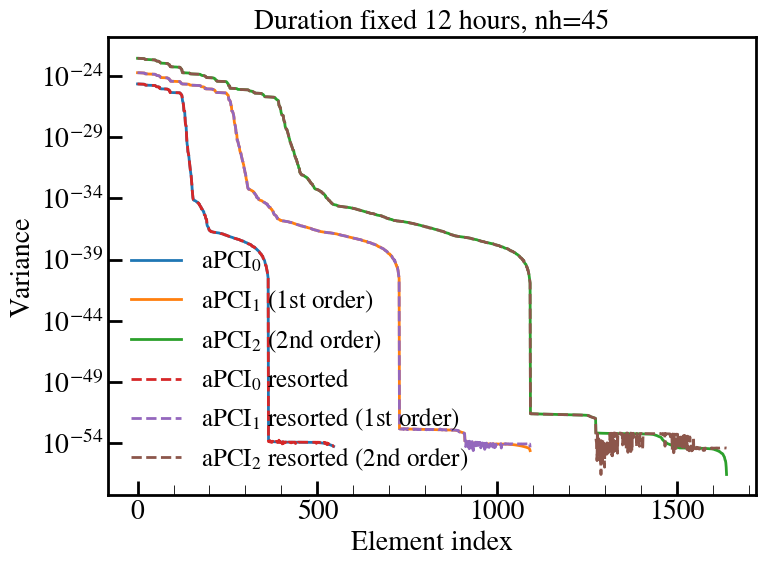

zsh:1: command not found: free


In [18]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance,
            #linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_variance,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if False:
    ax1.plot(pca_list_zm[0].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_variance,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
#for i in range(3):
#    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

## 3. Run channel analysis on the PCI output

i= 0
mean: -1.7397758239003345e-29
variance:  7.610652471834951e-55
mean: 4.189502888495551e-30
variance:  8.601151536304996e-55
mean: -6.494936827080626e-30
variance:  8.650898631184497e-55
mean: 9.231946915329414e-31
variance:  8.72967807615639e-55
i= 1
mean: 8.639930735383118e-30
variance:  6.465766323443917e-55
mean: -1.9476954330871737e-30
variance:  6.758402596592902e-55
mean: 1.9479078712835277e-29
variance:  6.787291533879204e-55
mean: -2.686799335896242e-29
variance:  7.085892171134558e-55


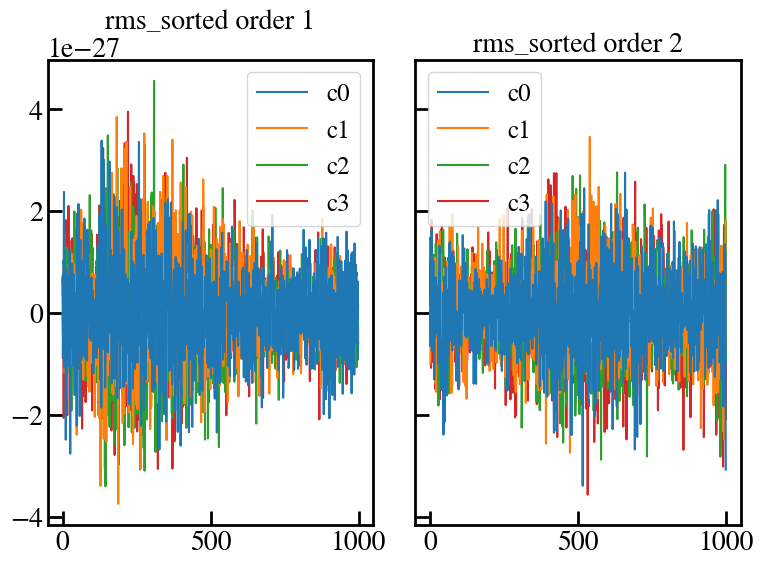

In [19]:
order=2
ev=100

filters=[pca_list_rs[order-1],pca_list_rs[order]]

sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=4,zero_mean=False,detrend=False)) for xf in filters]

channel_analysis.stationarity_plots(sets,title=['rms_sorted order '+str(order-1),'rms_sorted order '+str(order)])

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


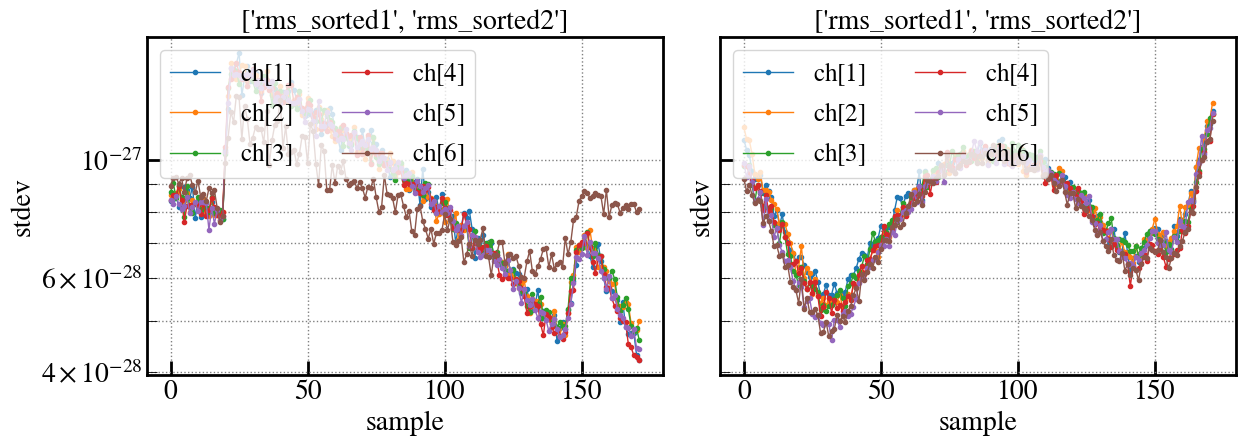

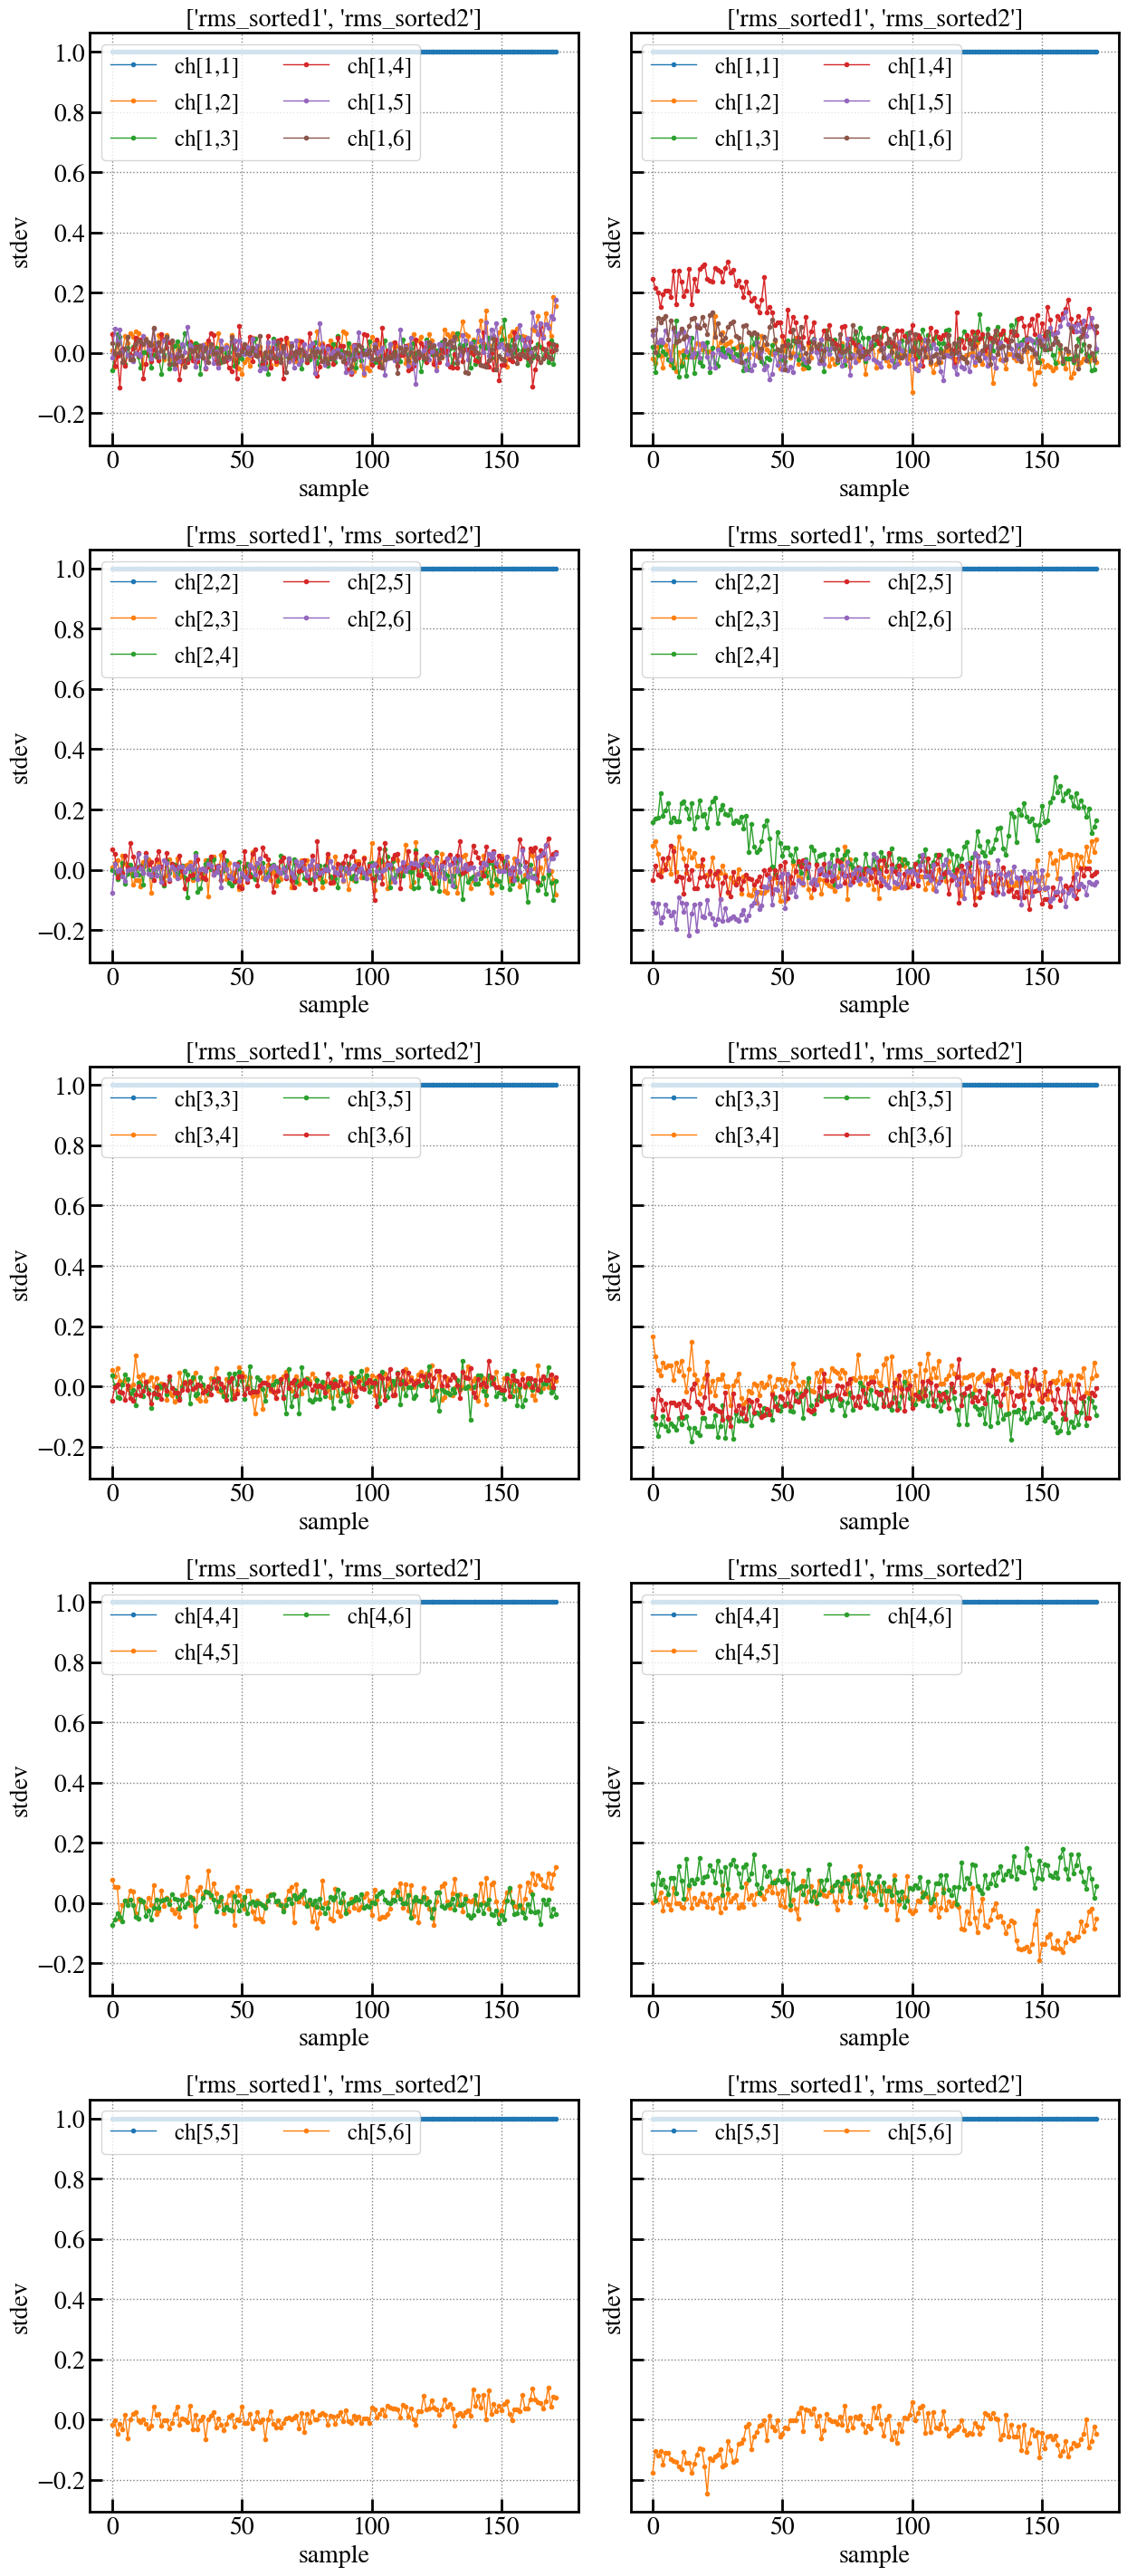

In [20]:
order=2
ev=100
#x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=1))
#channel_analysis.stationarity_plots([pca_list[order],pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,title=['standard','zero_mean','rms_sorted'])
#channel_analysis.temporal_variance_corr_plots([pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=3,title=['zero_mean','rms_sorted'])
#channel_analysis.pci_temporal_variance_corr_plots([pca_list_rs[order-1],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=6,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])
filters=[pca_list_rs[order-1],pca_list_rs[order]]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=6,zero_mean=False,detrend=False)) for xf in filters]
channel_analysis.temporal_variance_corr_plots(sets,nchan=6,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])

### 3.1 Frequency Domain analysis

In [21]:
def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat


In [22]:
nperseg = 2**16 #didn't work with some, too short data segment (6hr)?
nperseg = 2**14
kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}
freqs, y_welch_mat = compute_welch_matrix(y_full, **kwargs)
freqs, y_sec_welch_mat = compute_welch_matrix(y_sec, **kwargs)

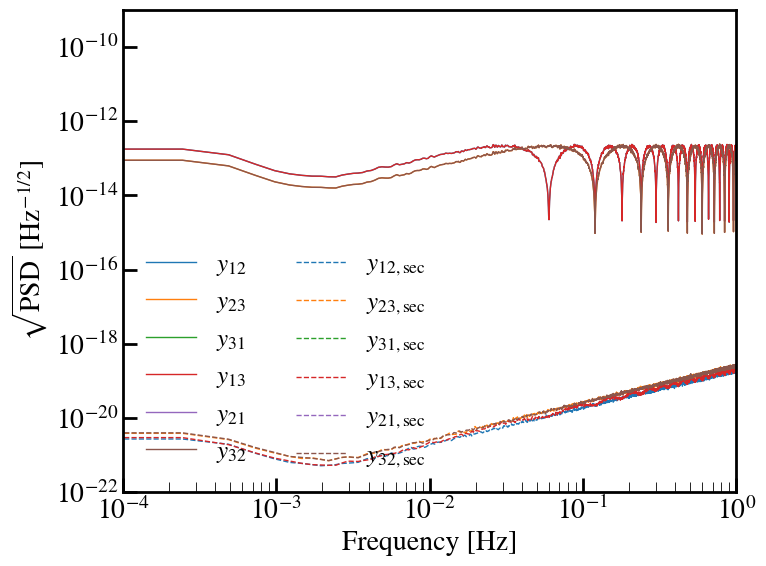

In [23]:
mosas_order = ['12', '23', '31', '13', '21', '32']

# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_welch_mat[:, i, i].real), 
                linewidth=1, 
                label=r'$y_{\mathrm{'+mosas_order[i]+'}}$',
                rasterized=True)
plt.gca().set_prop_cycle(None)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1,ls='--', 
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='lower left', ncol=2, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-22, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

## 4. Reconstruct single-link channels

Computing single link
single link shape (6, 172800)
single link shape (6, 172800)
Computed single link
i= 0
mean: -1.1360965172308145e-39
variance:  2.0951864496104475e-75
mean: 2.1301578862141542e-31
variance:  4.5815388549970876e-57
mean: -3.191434910772021e-45
variance:  2.6628398072069225e-86
mean: 1.1986608663067486e-30
variance:  3.2737733773580474e-57
mean: 1.1833328447506068e-39
variance:  2.1238288448452014e-75
mean: 0.0
variance:  0.0
i= 1
mean: 3.8596481218633306e-39
variance:  1.519774336951421e-74
mean: 8.357668315543516e-31
variance:  3.785262979690452e-58
mean: 3.217156217459956e-45
variance:  3.7109442622571245e-85
mean: 3.7555538465694325e-31
variance:  1.5735664106792155e-57
mean: -3.7074713204567427e-39
variance:  1.4989569437933727e-74
mean: 0.0
variance:  0.0
i= 2
mean: -4.454082459160653e-22
variance:  1.3942324328570675e-37
mean: 0.0
variance:  0.0
mean: 1.9656213270580817e-22
variance:  9.347730513243104e-38
mean: 4.6204082428416725e-40
variance:  3.596154353542

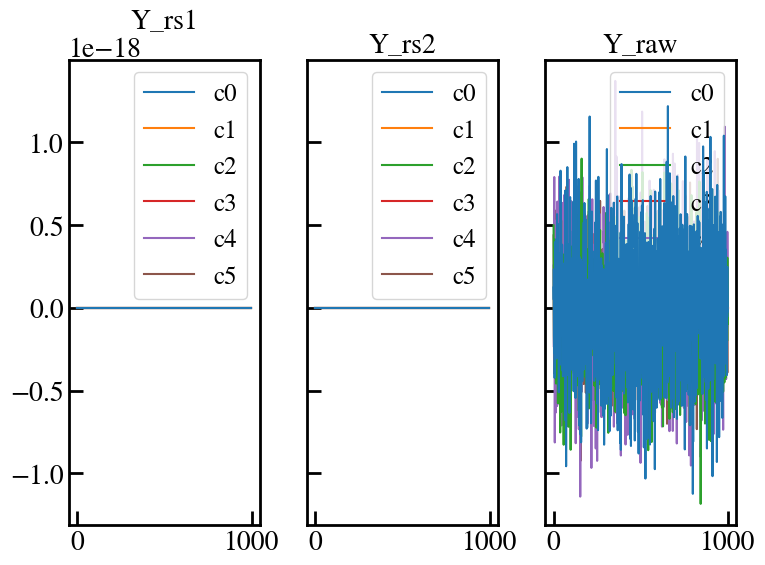

In [24]:
order=2
nchannels=10
ev=100
filters=[pca_list_rs[order-1],pca_list_rs[order]]
[xf.set_stencil(nchannels) for xf in filters]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=nchannels,zero_mean=False,detrend=False)) for xf in filters]
print("Computing single link")
Ysets=[xf.compute_single_links_from_channels(iset) for xf,iset in zip(filters,sets)]
titles=['Y_rs'+str(order-1),'Y_rs'+str(order)]
if True:
    Ysets+=[y_sec[nhalf:ns+nhalf, :].T]
    titles+=['Y_raw']
print("Computed single link")
channel_analysis.stationarity_plots(Ysets,title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


/Users/ecastel2/Documents/virtual-envs/miniconda/envs/spyder-env/lib/python3.12/site-packages/PCIpy-0.0.1-py3.12.egg/pcipy/channel_analysis.py:209: RuntimeWarning: invalid value encountered in divide


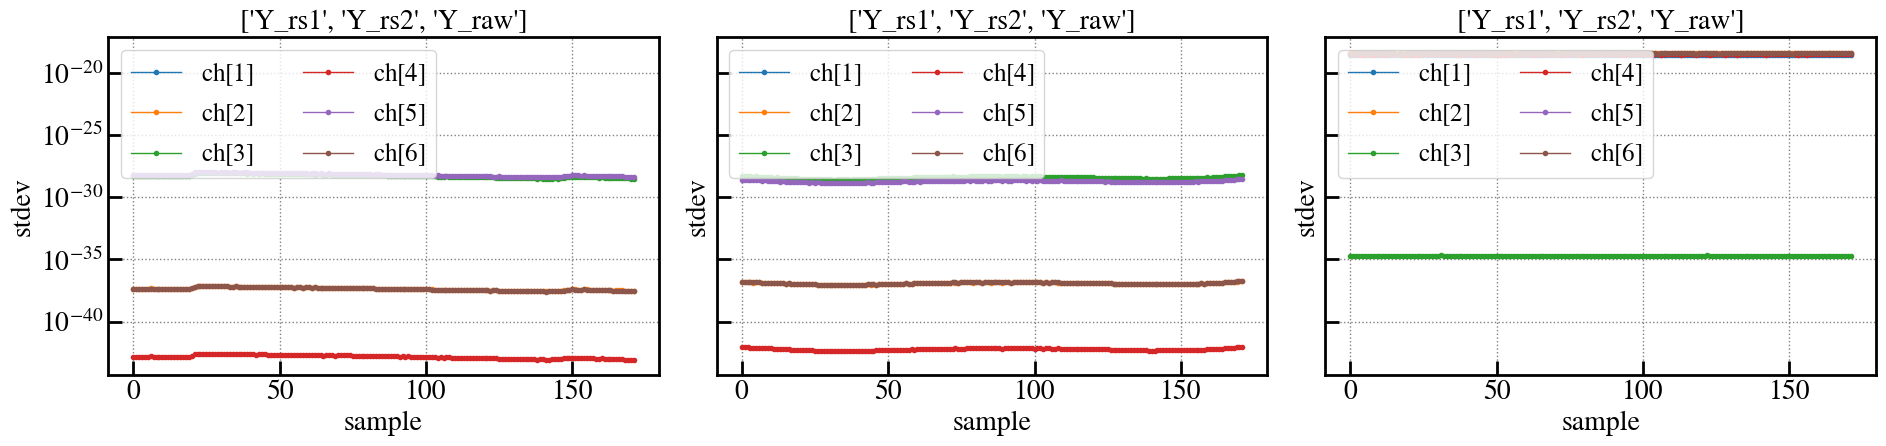

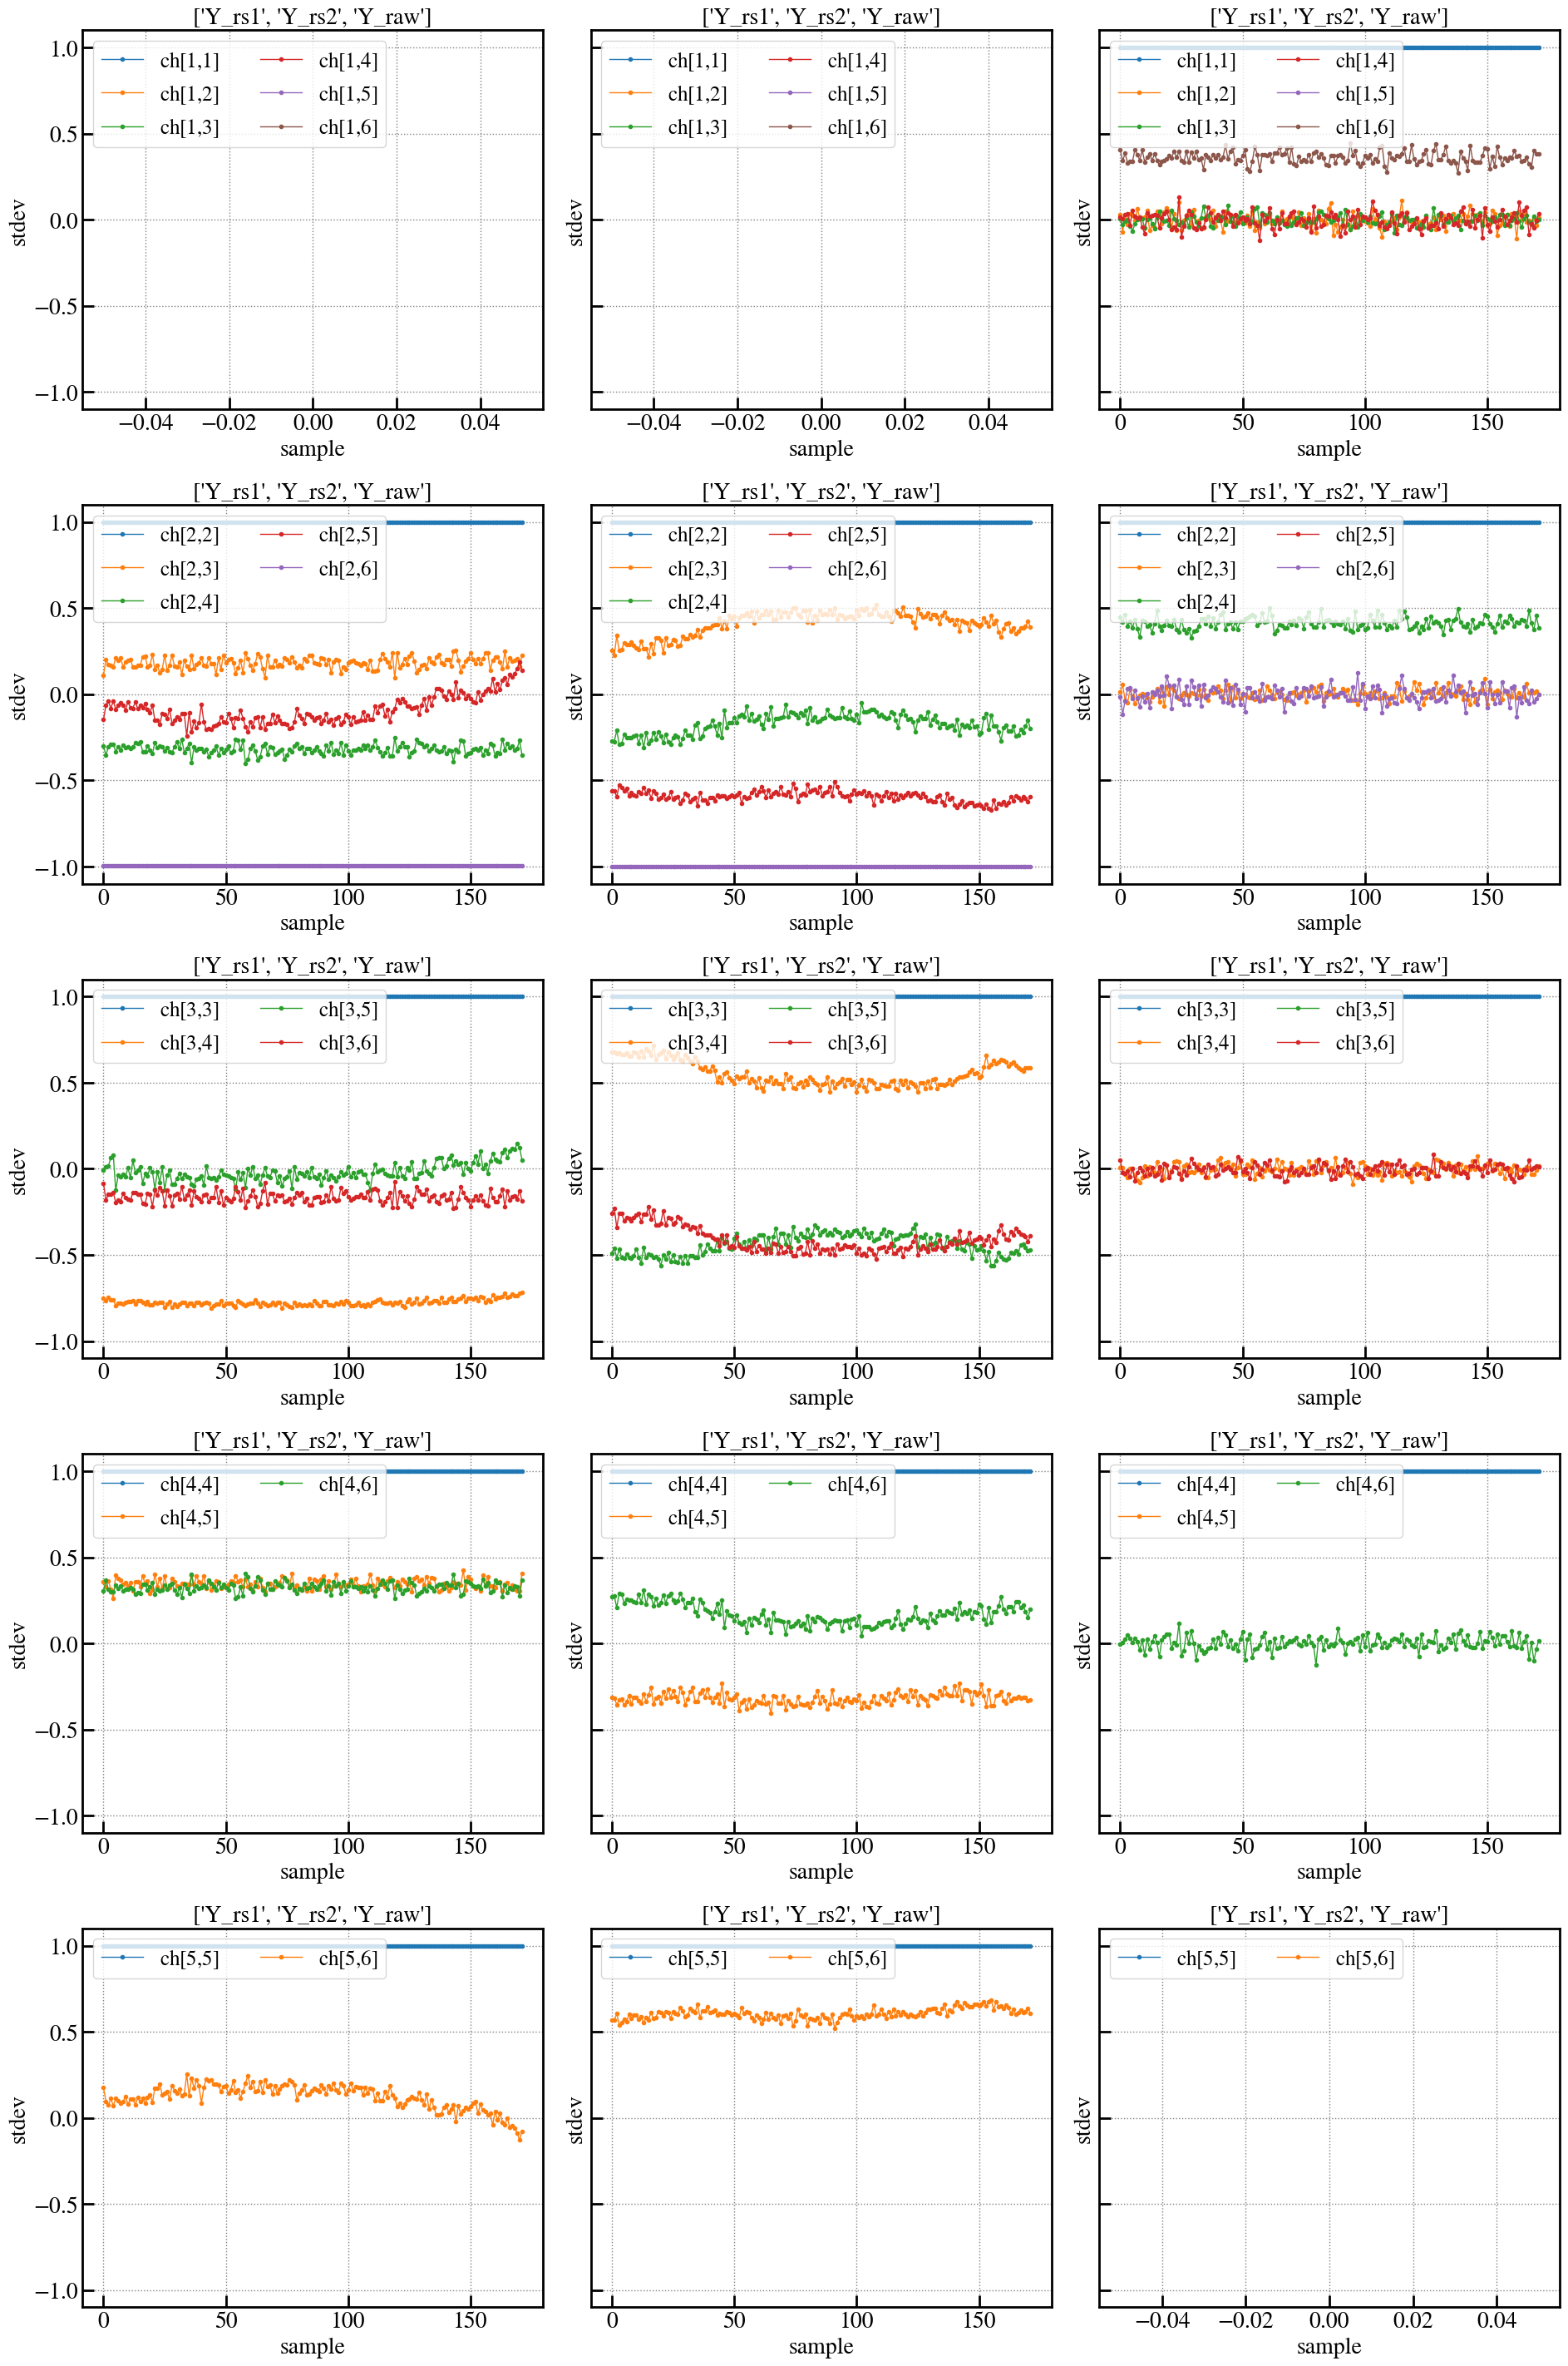

In [25]:
channel_analysis.temporal_variance_corr_plots(Ysets[:],nchan=6,title=titles)

In [26]:
freqs1, y_pci1_welch_mat = compute_welch_matrix(Ysets[0].T, **kwargs)
freqs2, y_pci2_welch_mat = compute_welch_matrix(Ysets[1].T, **kwargs)

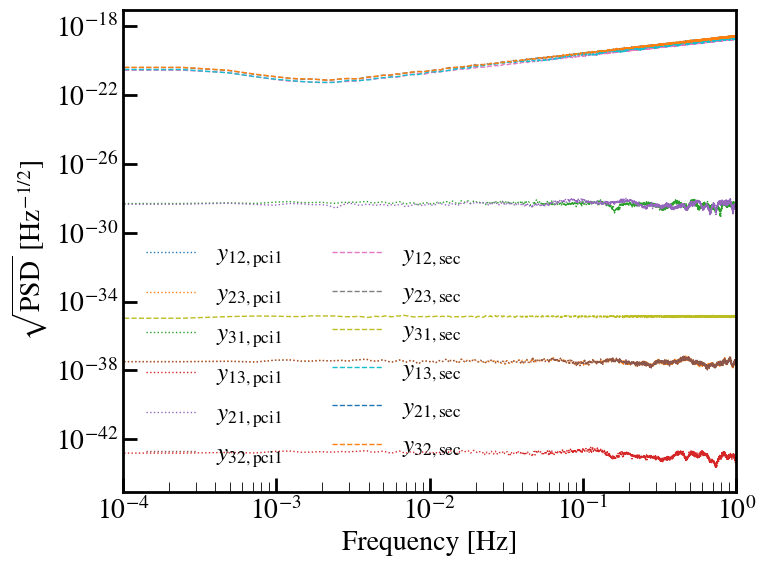

In [31]:
# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs1, np.sqrt(y_pci1_welch_mat[:, i, i].real), 
                linewidth=1, ls=':',
                label=r'$y_{\mathrm{'+mosas_order[i]+',pci1}}$',
               rasterized=True)
#for i in range(6):
#    axes.loglog(freqs, np.sqrt(y_pci2_welch_mat[:, i, i].real), 
#                linewidth=1, 
#                label=r'$y_{\mathrm{'+mosas_order[i]+',pci2}}$',
#               rasterized=True)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1, ls='--',
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='lower left', ncol=2, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
#axes.set_ylim([1e-25, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

#### For comparison, we also need the TDI data

In [32]:
pytdi_trim = 1000
pytdi_t0 = t0 - pytdi_trim * dt
pytdi_size = n_data + pytdi_trim
skip = pytdi_trim

In [33]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
#tdipath2 = workdir +  dtpath['noise'] + datasets['noise'] + 'noise_tdi2_4Hz.h5'
# open hdf5 TDI file
#tdi1 = h5py.File(tdipath1, 'r')
#tdi2 = h5py.File(tdipath2, 'r')

#x2_noise = tdi2['x'][()] / central_freq
#y2_noise = tdi2['y'][()] / central_freq
#z2_noise = tdi2['z'][()] / central_freq

X, Y, Z = X2, Y2, Z2

# Build other 2.0 Michelson variables
X_data = X.build(**data_noise.args)
Y_data = Y.build(**data_noise.args)
Z_data = Z.build(**data_noise.args)
# Apply TDI 2.0
x2_noise = X_data(data_noise.measurements) / central_freq
y2_noise = Y_data(data_noise.measurements) / central_freq
z2_noise = Z_data(data_noise.measurements) / central_freq

INFO:pytdi.core:Building combination '<pytdi.core.LISATDICombination object at 0x166b0dbe0>'
INFO:pytdi.core:Building combination '<pytdi.core.LISATDICombination object at 0x166b0f320>'
INFO:pytdi.core:Building combination '<pytdi.core.LISATDICombination object at 0x166b64d40>'
INFO:pytdi.core:Evaluate combination '<pytdi.core.LISATDICombination object at 0x166b0dbe0>'
INFO:pytdi.core:Evaluate combination '<pytdi.core.LISATDICombination object at 0x166b0f320>'
INFO:pytdi.core:Evaluate combination '<pytdi.core.LISATDICombination object at 0x166b64d40>'


In [34]:
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqstdi, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)

In [35]:
p_tdi2_n_mat.shape

(8193, 3, 3)

/Users/ecastel2/Documents/virtual-envs/miniconda/envs/spyder-env/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1037800 is greater than input length  = 1035800, using nperseg = 1035800
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Text(0, 0.5, '$S_\\text{TDI}(f)$')

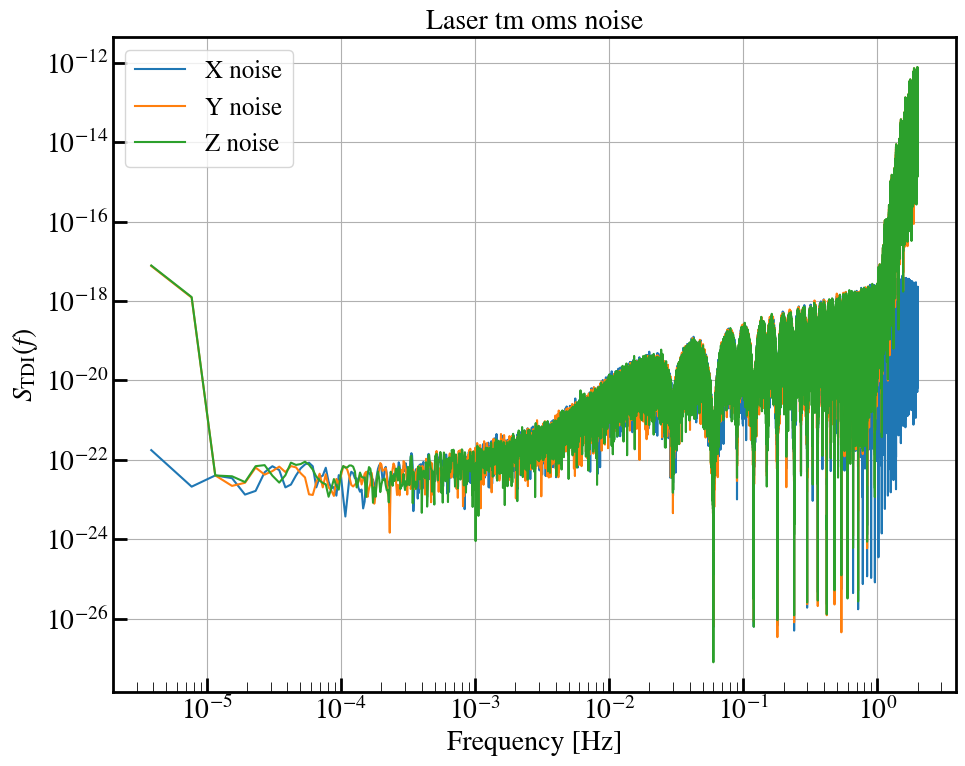

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharex = False)
 
ax.set_title('Laser tm oms noise')

kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": pytdi_size,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

f, xpsd = signal.welch(x2_noise[pytdi_trim:], **kwargs)
f, ypsd = signal.welch(y2_noise[pytdi_trim:], **kwargs)
f, zpsd = signal.welch(z2_noise[pytdi_trim:], **kwargs)

ax.loglog(f[1:], np.sqrt(xpsd[1:]), label = 'X noise')
ax.loglog(f[1:], np.sqrt(ypsd[1:]), label = 'Y noise')
ax.loglog(f[1:], np.sqrt(zpsd[1:]), label = 'Z noise')
ax.grid()
ax.legend()
# ax.set_xlim([1e-5, 1e-1])
# ax.set_ylim([1e-25, 1e-17])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'$S_\text{TDI}(f)$')

Alertnative Y reconstruction

In [ ]:
    def filter_single_link_data(self, ydata,n_channels=None):
        '''
        Compute recovered single-link channel vectors from a set of single-link data. This should yield 
        identical results to appropriately called compute_single_link_from_channels but we first implement
        separately for testing, since the stencil_compts stuff is new. This one is more low-level and 
        doesn't assum the stencil is selected.
        
        Parameters
        ----------
        ydata : ndarray 
            The raw single-link data-set to be transformed.

        Returns
        -------
        reconstructed_ydata : ndarray
            Reconstructed single link data channels
        '''
        if n_channels is None: n_channels=self.maxcompts
        y_transformer=self.components[-n_channels:,:6].T

        chans_data = self.apply_for_channels(ydata, n_channels)
        Z=np.dot(y_transformer,chans_data)
        print('single link data shape', Z.shape)
        return Z

In [ ]:
Zsets=[np.array(xf.filter_single_link_data(y_full[:ns+2*nhalf, :].T, n_channels=nchannels)) for xf in filters]
print("Comparing single link")
diff=[Zsets[i]-Ysets[i] for i in range(order)]
print(diff)

## 5. Estimate sensitivity
### Computation of empirical response with welch periodograms
Based and empirical sensitivity calculation simulated signal over simulated noise as developed in initial-dev-from-pylisa

In [ ]:
# Some options and prep for the welch_matrix calc
nperseg = 1e4
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

#and for the orthogonalization...
#multiple_dot = lambda a,b: np.einsum("ijk, ikl -> ijl", a, b)
def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)


In [ ]:

def estimate_sensitivity(pci, data_n, data_gw, n_channels=6, joint=True, single_link=False, welch_kwargs=welch_kwargs):
    
    # PCI transformation vector, size n_channel x p
    #v_pci = pci.v_pci(n_channels)
    # Projection of the data segment t
    #print('compute noise channels')
    #print('for',n_channels,'channels')
    #print('components shape',pci.components.shape)
    if single_link:
        e_pci_n = pci.filter_single_link_data(data_n,n_channels).T
        e_pci_gw = pci.filter_single_link_data(data_gw,n_channels).T
    else:
        e_pci_n = pci.apply_for_channels(data_n,n_channels).T
        e_pci_gw = pci.apply_for_channels(data_gw,n_channels).T
    #print(e_pci_n.shape,e_pci_n.shape)
    #print('compute welch')
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_n_mat = compute_welch_matrix(e_pci_n, **welch_kwargs)
    print(freqs, e_pci_n_mat)
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_gw_mat = compute_welch_matrix(e_pci_gw, **welch_kwargs)
    print(freqs, e_pci_gw_mat)
    # Orthogonalization
    _, s, vh = np.linalg.svd(e_pci_n_mat)
    # Apply the orthogonal transformation to the GW signal    
    e_pci_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_gw_mat, np.swapaxes(vh, 1, 2).conj()))
    # Apply the orthogonal transformation to the noise covariance
    e_pci_n_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_n_mat, np.swapaxes(vh, 1, 2).conj()))
    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    pci_sens = np.array([np.abs(e_pci_n_mat_ortho[:, j, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    
    print("Computation completed.")
    if joint:
        pci_sens = 1 / np.sum(1/np.array(pci_sens), axis=1)
    
    return freqs, pci_sens

def process_data(y_noise, y_gw, fs, nhalf, order=1, n_channels=6, pca_y_noise=None, joint=False, pci_kwargs={}, welch_kwargs={}):
    '''
    Apply PCI and compute sensitivity all wrapped up together. If pda_y_noise is provided it is used
    only for computing the PCI and y_noise is used only for the sensitivity application
    '''
    
    if pca_y_noise is None: pca_y_noise=y_noise
        
    print('nhalf:',nhalf, 'sens data_size:',len(y_noise),'pca data_size:',len(pca_y_noise))
    
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # data_noise = Data.from_instrument(instr_data)

    print('compute PCI')
    pci=pci_filter.PCIFilter(y_noise, fs, maxcompts=10, nhalf=nhalf,order=order,**pci_kwargs)
    
    result=estimate_sensitivity(pci, y_noise, y_gw, n_channels=n_channels, joint=joint, welch_kwargs=welch_kwargs)
    del(pci)
    
    return result

#### We need to read matching GW simulations results for the empirical sensitivity calculation

In [ ]:
gw_path = workdir+dtpath["point_source"]+datasets["point_source"][:]+ '_measurements_4Hz.h5'

data_gw = Data.from_gws(gw_path,orbits)

#gw_dataset='tps/y'
#hdf5 = h5py.File(gw_path, 'r')
#dset=hdf5[gw_dataset]

#measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(mosas_order)}
#hdf5.close()

y_list = [data_gw.measurements[f'isi_{link}'] for link in mosas_order]
y_gw = np.array(y_list, dtype=np.float64).T[skip:, :]


In [ ]:
tdi2_gw_file = workdir+dtpath["point_source"]+datasets["point_source"][:]+"_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()]
y2_gw = hdf5['y'][()]
z2_gw = hdf5['z'][()]
hdf5.close()

In [ ]:
# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, 

multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
mean_tdi2 = 1 / np.sum(
    np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)]), axis=0)

#### PCI channel sensitivities

In [ ]:
#Test as it appears in the initial-dev notebook
nh=45
pci_sens_list = [
#    ["PCI-0 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-1 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-2 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-0 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
#    ["PCI-1 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
    ["PCI-2 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, fs, nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=welch_kwargs)] 
]

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
axes[0].legend(loc='upper left', ncol=2)
axes[0].set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes[0].set_xlim([1e-3, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes[0].grid(linewidth=1, which='both', color='gray', linestyle='dotted')

for j in range(len(pci_sens_list)):
    #print(j)
    axes[1].loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes[1].legend(loc='upper left', ncol=2)
axes[1].set_xlabel("Frequency [Hz]")
axes[1].set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes[1].set_xlim([1e-3, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes[1].grid(linewidth=1, which='both', color='gray', linestyle='dotted')
plt.show()

In [ ]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" rms", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]


In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

Reconstructed single link sensitivities

In [ ]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]


In [ ]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
#axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()